# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход пол и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации
Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)
Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Дедлайн 30 ноября
# Жесткий дедлайн - 7 декабря

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.
Присылать в виде ноутбука


In [ ]:
import numpy as np
import pandas as pd
import tqdm
import re

In [ ]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
%matplotlib inline

In [ ]:
books = pd.read_csv("https://raw.githubusercontent.com/vadim0912/park_ML/master/lecture07/HW/BX-Books.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
books

ISBN  ...                                        Image-URL-L
0       0195153448  ...  http://images.amazon.com/images/P/0195153448.0...
1       0002005018  ...  http://images.amazon.com/images/P/0002005018.0...
2       0060973129  ...  http://images.amazon.com/images/P/0060973129.0...
3       0374157065  ...  http://images.amazon.com/images/P/0374157065.0...
4       0393045218  ...  http://images.amazon.com/images/P/0393045218.0...
...            ...  ...                                                ...
271355  0440400988  ...  http://images.amazon.com/images/P/0440400988.0...
271356  0525447644  ...  http://images.amazon.com/images/P/0525447644.0...
271357  006008667X  ...  http://images.amazon.com/images/P/006008667X.0...
271358  0192126040  ...  http://images.amazon.com/images/P/0192126040.0...
271359  0767409752  ...  http://images.amazon.com/images/P/0767409752.0...

[271360 rows x 8 columns]

In [ ]:
interactions = pd.read_csv("https://raw.githubusercontent.com/vadim0912/park_ML/master/lecture07/HW/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [ ]:
interactions

User-ID         ISBN  Book-Rating
0         276725   034545104X            0
1         276726   0155061224            5
2         276727   0446520802            0
3         276729   052165615X            3
4         276729   0521795028            6
...          ...          ...          ...
1149775   276704   1563526298            9
1149776   276706   0679447156            0
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[1149780 rows x 3 columns]

In [ ]:
users = pd.read_csv('https://raw.githubusercontent.com/vadim0912/park_ML/master/lecture07/HW/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
users

User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]

# 1.Summary-based рекомендации

Для использования Summary-based рекоммендации необходимо разбить пользователей на кластеры, а затем при добавлении нового пользователя относить его к уже существующему кластеру и рекомендовать топ книг, основываясь на самых лучших книгах внутри этого кластера. На кластеры будем разбивать по возрасту и местонахождению. Исходя из этого, необходимо исключить выбросы по возрасту, а также пользователей с отсутствующими значениями в графе возраст, т.к. восстановление данного значения проблематично

## очистка от выбросов

Будем считать, что возраст не может превосходить 100 лет, а также оценки,сделанные людьми до 5 лет, также являются нерелевантными. Также удалим людей, чей возраст не указан.

In [ ]:
users_sb = users.loc[(users.Age <= 100) & (users.Age >= 5)]
users_sb

User-ID                            Location   Age
1             2           stockton, california, usa  18.0
3             4           porto, v.n.gaia, portugal  17.0
5             6       santa monica, california, usa  61.0
9            10          albacete, wisconsin, spain  26.0
10           11      melbourne, victoria, australia  14.0
...         ...                                 ...   ...
278848   278849         georgetown, ontario, canada  23.0
278850   278851                  dallas, texas, usa  33.0
278851   278852     brisbane, queensland, australia  32.0
278852   278853      stranraer, n/a, united kingdom  17.0
278854   278855  tacoma, washington, united kingdom  50.0

[166848 rows x 3 columns]

Также преобразуем Location для лучшей кластеризации

In [ ]:
users_sb['Location'].apply(lambda x: x.count(',')).value_counts()

2    165910
3       875
4        47
5         8
6         4
8         1
7         1
1         1
0         1
Name: Location, dtype: int64

In [ ]:
import re
users_sb = users_sb.loc[users_sb['Location'].apply(lambda x: x.count(',')) == 2]
users_sb.Location = users_sb.Location.apply(lambda x: re.sub(r"[^A-Za-z,]+", '', x))
users_sb = users_sb.join(users['Location'].str.replace(" ","").str.split(',',2,expand=True)).rename(columns={0:'City', 1:'State', 2:'Country'})
users_sb

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


User-ID                         Location  ...       State        Country
1             2          stockton,california,usa  ...  california            usa
3             4            porto,vngaia,portugal  ...    v.n.gaia       portugal
5             6       santamonica,california,usa  ...  california            usa
9            10         albacete,wisconsin,spain  ...   wisconsin          spain
10           11     melbourne,victoria,australia  ...    victoria      australia
...         ...                              ...  ...         ...            ...
278848   278849        georgetown,ontario,canada  ...     ontario         canada
278850   278851                 dallas,texas,usa  ...       texas            usa
278851   278852    brisbane,queensland,australia  ...  queensland      australia
278852   278853       stranraer,na,unitedkingdom  ...         n/a  unitedkingdom
278854   278855  tacoma,washington,unitedkingdom  ...  washington  unitedkingdom

[165910 rows x 6 columns]

In [ ]:
users_sb.drop(columns='Location', inplace=True)

In [ ]:
interactions_sb = interactions.loc[interactions['User-ID'].isin(users_sb['User-ID'])]

In [ ]:
interactions_sb['Book-Rating'].value_counts()

0     529212
8      72452
10     58945
7      51906
9      49808
5      31102
6      24884
4       5898
3       3862
2       1777
1       1031
Name: Book-Rating, dtype: int64

как мы видим, довольно много отзывов с нулевым значением отзыва, удалим их

In [ ]:
interactions_sb = interactions_sb.loc[interactions_sb['Book-Rating'] != 0]

In [ ]:
books_meets_sb = interactions_sb.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [ ]:
books_meets_sb

ISBN  user_num
0           0330299891         1
1           0375404120         1
2         '9607092910'         1
3           )416195113         1
4           )452273056         1
...                ...       ...
145823  \8804520159\""         1
145824  \8887517452\""         1
145825  \8888809228\""         1
145826      ooo7156103         1
145827       Ô½crosoft         1

[145828 rows x 2 columns]

In [ ]:
user_meets_sb = interactions_sb.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [ ]:
user_meets_sb

User-ID  books_num
0           10          1
1           19          1
2           42          1
3           44          1
4           51          1
...        ...        ...
46146   278844          3
46147   278846          1
46148   278849          1
46149   278851         14
46150   278852          1

[46151 rows x 2 columns]

In [ ]:
interactions_sb = interactions_sb.merge(books_meets_sb, on=["ISBN"]).merge(user_meets_sb, on=["User-ID"])

In [ ]:
interactions_sb

User-ID         ISBN  Book-Rating  user_num  books_num
0        276729   052165615X            3         1          2
1        276729   0521795028            6         1          2
2        276737   0600570967            6         1          1
3        276745    342310538           10         1          1
4        276747   0060517794            9        24          5
...         ...          ...          ...       ...        ...
301660   276664   0004703723            9         1          4
301661   276664   0140136908            7         1          4
301662   276664   0631189629            9         1          4
301663   276664   0747205051            7         1          4
301664   276723  05162443314            8         1          1

[301665 rows x 5 columns]

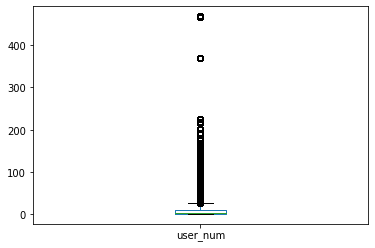

In [ ]:
interactions_sb.user_num.plot.box()

In [ ]:
books.loc[books.ISBN.isin(interactions_sb.loc[interactions_sb.user_num > 300].ISBN.value_counts().index)]

ISBN  ...                                        Image-URL-L
26   0971880107  ...  http://images.amazon.com/images/P/0971880107.0...
408  0316666343  ...  http://images.amazon.com/images/P/0316666343.0...
748  0385504209  ...  http://images.amazon.com/images/P/0385504209.0...

[3 rows x 8 columns]

Последние 2 книги, достаточно популярны и большое количество отзывов по этим книгам не выглядит как технические выбросы, а вот количество отзывов по первой книги выглядит как выброс

In [ ]:
interactions_sb = interactions_sb.loc[interactions_sb.ISBN != '0971880107']

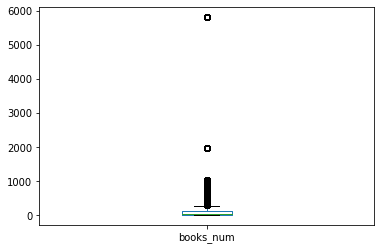

In [ ]:
interactions_sb.books_num.plot.box()

Удалим пользователей, которые отправили больше, чем 1500 отзывов

In [ ]:
interactions_sb = interactions_sb.loc[interactions_sb.books_num < 1500]

In [ ]:
interactions_sb

User-ID         ISBN  Book-Rating  user_num  books_num
0        276729   052165615X            3         1          2
1        276729   0521795028            6         1          2
2        276737   0600570967            6         1          1
3        276745    342310538           10         1          1
4        276747   0060517794            9        24          5
...         ...          ...          ...       ...        ...
301660   276664   0004703723            9         1          4
301661   276664   0140136908            7         1          4
301662   276664   0631189629            9         1          4
301663   276664   0747205051            7         1          4
301664   276723  05162443314            8         1          1

[293426 rows x 5 columns]

In [ ]:
interactions_sb = interactions_sb.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])
interactions_sb

User-ID  ...                                         Book-Title
0        276729  ...                                     Help!: Level 1
1        276729  ...  The Amsterdam Connection : Level 4 (Cambridge ...
2        276747  ...                           Little Altars Everywhere
3        278843  ...                           Little Altars Everywhere
4          4017  ...                           Little Altars Everywhere
...         ...  ...                                                ...
258776   276660  ...                           ROBOT RACE (MICRO ADV 6)
258777   276664  ...                     Dictionary Of Economics-2Nd Ed
258778   276664  ...    History of Economic Thought (Penguin Economics)
258779   276664  ...  British Social Policy Since 1945 (Making Conte...
258780   276664  ...                    Murderous Women: True Talesof W

[258781 rows x 7 columns]

## Feature Preprocessing

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
interactions_sb["product_id"] = le.fit_transform(interactions_sb["ISBN"])
interactions_sb["vid"] = le.fit_transform(interactions_sb["User-ID"])

In [ ]:
interactions_sb.head()

User-ID        ISBN  ...  product_id    vid
0   276729  052165615X  ...       47182  39600
1   276729  0521795028  ...       47200  39600
2   276747  0060517794  ...        2404  39601
3   278843  0060517794  ...        2404  39916
4     4017  0060517794  ...        2404    563

[5 rows x 9 columns]

In [ ]:
users_sb.Country.value_counts()

usa              75768
spain            12447
unitedkingdom    12259
canada           11279
germany          10529
                 ...  
lithuania"           1
l                    1
goteborg             1
sanbernardino        1
peru"                1
Name: Country, Length: 372, dtype: int64

In [ ]:
resonable_countries = list(users_sb.Country.value_counts()[(users_sb.Country.value_counts()>30) & (users_sb.Country.value_counts().index != '')].index)
resonable_countries

['usa',
 'spain',
 'unitedkingdom',
 'canada',
 'germany',
 'australia',
 'italy',
 'france',
 'portugal',
 'newzealand',
 'brazil',
 'netherlands',
 'switzerland',
 'china',
 'argentina',
 'india',
 'austria',
 'belgium',
 'malaysia',
 'mexico',
 'finland',
 'sweden',
 'singapore',
 'philippines',
 'ireland',
 'turkey',
 'poland',
 'denmark',
 'iran',
 'chile',
 'greece',
 'pakistan',
 'romania',
 'indonesia',
 'israel',
 'southafrica',
 'norway',
 'nigeria',
 'slovakia',
 'croatia',
 'japan',
 'peru',
 'russia',
 'costarica',
 'czechrepublic',
 'venezuela',
 'yugoslavia',
 'colombia',
 'hongkong',
 'spain"',
 'egypt',
 'southkorea',
 'bulgaria',
 'vietnam',
 'taiwan',
 'luxembourg',
 'slovenia',
 'thailand',
 'unitedarabemirates',
 'portugal"',
 'hungary',
 'ghana',
 'saudiarabia',
 'españa',
 'bosniaandherzegovina',
 'andorra',
 'srilanka',
 'guatemala',
 'ecuador',
 'cuba',
 'bangladesh',
 'lithuania',
 'panama',
 'lafrance']

In [ ]:
users_sb.Country = users_sb.Country.apply(lambda x: x if x in resonable_countries else 'others')
users_sb

User-ID   Age         City       State        Country
1             2  18.0     stockton  california            usa
3             4  17.0        porto    v.n.gaia       portugal
5             6  61.0  santamonica  california            usa
9            10  26.0     albacete   wisconsin          spain
10           11  14.0    melbourne    victoria      australia
...         ...   ...          ...         ...            ...
278848   278849  23.0   georgetown     ontario         canada
278850   278851  33.0       dallas       texas            usa
278851   278852  32.0     brisbane  queensland      australia
278852   278853  17.0    stranraer         n/a  unitedkingdom
278854   278855  50.0       tacoma  washington  unitedkingdom

[165910 rows x 5 columns]

In [ ]:
Age_groups = pd.DataFrame({'age_group': ['Childhood', 'Youth', 'Adulthood', 'Seniority'],
                           'start': [0., 15., 25., 65.],
                           'end': [14., 24., 64., 101.]})
Age_groups

age_group  start    end
0  Childhood    0.0   14.0
1      Youth   15.0   24.0
2  Adulthood   25.0   64.0
3  Seniority   65.0  101.0

In [ ]:
def get_age_group(age):
    return Age_groups.loc[(Age_groups.start <= age) & (Age_groups.end >= age), 'age_group'].iloc[0]

users_sb.Age = users_sb.Age.apply(get_age_group)
users_clusters = users_sb[['Age', 'Country']].drop_duplicates().reset_index(drop=True)
users_clusters

Age               Country
0        Youth                   usa
1        Youth              portugal
2    Adulthood                   usa
3    Adulthood                 spain
4    Childhood             australia
..         ...                   ...
253  Childhood            bangladesh
254  Childhood              srilanka
255  Childhood                 japan
256  Seniority              slovenia
257  Seniority  bosniaandherzegovina

[258 rows x 2 columns]

## Model

В результате получаем 258 кластеров

Создадим класс, который будет выдавать по стране и возрасту заданное количество топ книг. Несмотря на то, что предлагается использовать среднее, будем использовать аналог f_beta score, где в качестве полноты будет avg(Book-Rating)/max(Book-Rating), а в качестве точности user_num/max(user_num), и beta = 2, т.к. оценочно, рейтинг книги примерно в 2р. более важен, чем количество оценок.Просто среднее использовать плохо т.к. выборка оценок [5, 5] имеет среднее 5, а выборка [4.6, 4.7, ... , 4.9] размером 100, имеющая среднее 4.7 будет менее предпочтительной, чем первая, что неправильно.

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(data):
    measure = data['Book-Title'].values
    top_n = 3
    picture_urls = data.picture_url.values
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            a.set_title("{}\nrecommendation number {}".format(measure[cnt], cnt+1), color='white')
            cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [ ]:
class SummaryBased():
    def __init__(self, clusters, users=users_sb, data=interactions_sb, age_groups=Age_groups, coutries=resonable_countries):
        self.clusters = clusters
        self.users = users
        self.data = data
        self.age_groups = Age_groups
        self.countries = resonable_countries
    
    def get_book_score(self, data, b=2):
        max_user_num = data.user_num.max()
        max_rating = data['Book-Rating'].max()
        temp = data.groupby(by=['user_num', 'Book-Title'])['Book-Rating'].mean().reset_index()
        temp = pd.merge(temp, data[['Book-Title', 'picture_url']].drop_duplicates(subset='Book-Title'), how='inner', on='Book-Title')
        temp['Book-Rating'] = temp['Book-Rating'] / max_rating
        temp['user_num'] = temp['user_num'] / max_user_num
        temp = temp.assign(score = (1 + b**2) * (temp['Book-Rating'] * temp['user_num'])/ ((b**2 * temp['user_num']) + temp['Book-Rating'])).sort_values(by='score', ascending=False)
        return temp

    def top_items(self, country, age, top_count=10):
        country = country if country in self.countries else 'others'
        age = self.age_groups.loc[(self.age_groups.start <= age) & (self.age_groups.end >= age), 'age_group'].iloc[0]
        if self.clusters.loc[(self.clusters.Age == age) & (self.clusters.Country == country)].shape[0] == 0:
            print("Sorry, but we don't have suitable recommendation for you")
            return
        suitable_users = self.users.loc[(self.users.Age == age) & (self.users.Country == country), 'User-ID']
        suitable_data = pd.merge(self.data, suitable_users, how='inner', on='User-ID')
        book_score = self.get_book_score(suitable_data)
        if book_score.shape[0] == 0:
            print("Sorry, but we don't have suitable recommendation for you")
            return
        rec_imaging(book_score[:top_count])
        return book_score

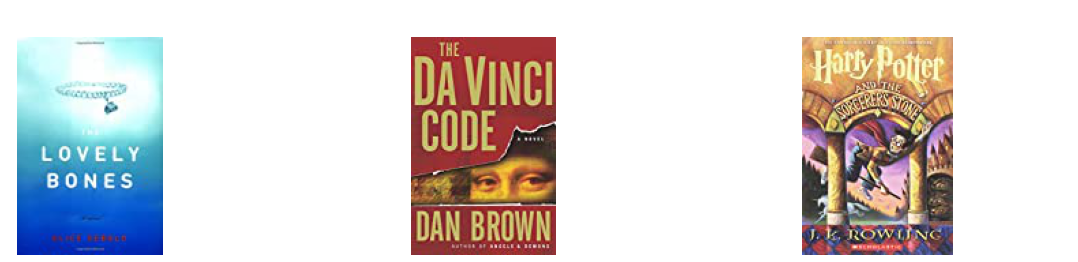

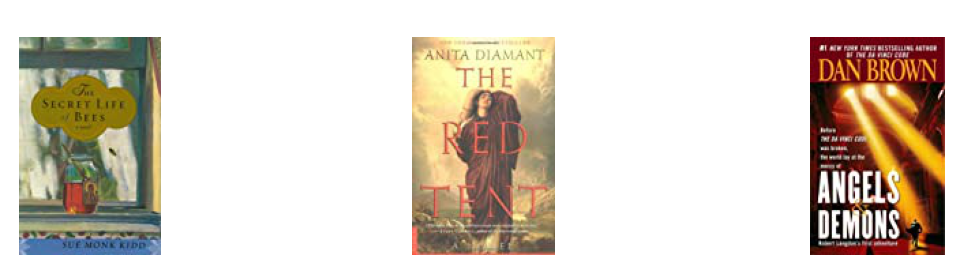

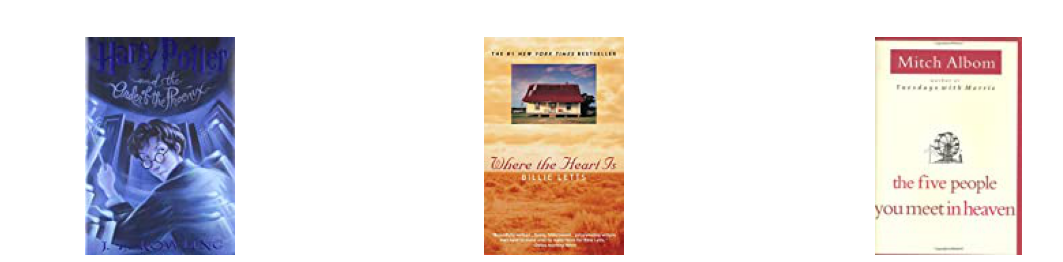

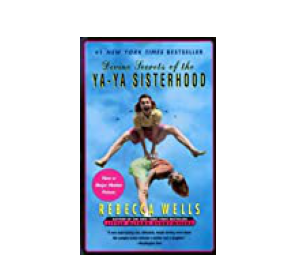

In [ ]:
a = SummaryBased(clusters=users_clusters)
check = a.top_items(country='usa', age=40.)

In [ ]:
check

user_num  ...     score
67713  1.000000  ...  0.851528
57453  0.792291  ...  0.832010
67711  0.468951  ...  0.763262
67306  0.462527  ...  0.729045
67712  0.481799  ...  0.724084
...         ...  ...       ...
39673  0.002141  ...  0.009862
15481  0.002141  ...  0.009862
6401   0.002141  ...  0.009862
35115  0.002141  ...  0.009862
34935  0.002141  ...  0.009862

[67714 rows x 5 columns]

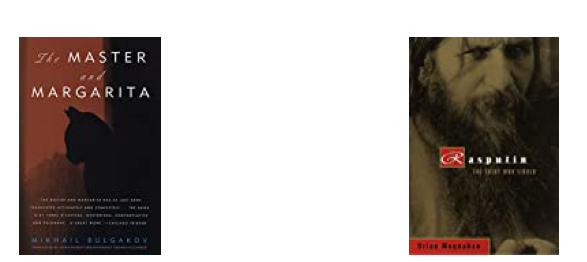

In [ ]:
check = a.top_items(country='russia', age=40.)

In [ ]:
check

user_num  ...     score
1  1.000000  ...  1.000000
0  0.055556  ...  0.227273

[2 rows x 5 columns]

# 2.User сlustering

Будем кластеризовать пользователей только на основе их предпочтений исходя из матрицы взаимодействий

В данном случае, нам не важна информация о пользователе, следовательно мы не будем фильтровать пользователь основываясь на пропусках в таблице users

## Preprocessing

In [ ]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [ ]:
books_meets

ISBN  user_num
0        0330299891         2
1        0375404120         2
2        0586045007         1
3        9022906116         2
4        9032803328         1
...             ...       ...
340551     cn113107         1
340552   ooo7156103         1
340553   §423350229         1
340554  ´3499128624         1
340555    Ô½crosoft         1

[340556 rows x 2 columns]

In [ ]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [ ]:
user_meets

User-ID  books_num
0             2          1
1             7          1
2             8         18
3             9          3
4            10          2
...         ...        ...
105278   278846          2
105279   278849          4
105280   278851         23
105281   278852          1
105282   278854          8

[105283 rows x 2 columns]

In [ ]:
interactions_uc = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [ ]:
interactions_uc

User-ID         ISBN  Book-Rating  user_num  books_num
0         276725   034545104X            0        60          1
1           2313   034545104X            5        60         37
2           2313   0812533550            9        23         37
3           2313   0679745580            8        55         37
4           2313   0060173289            9       130         37
...          ...          ...          ...       ...        ...
1149775   276647   0689822294           10         1          2
1149776   276660   0583307841            8         1          1
1149777   276663   0533233661            5         1          1
1149778   276668   3423120754            8         1          1
1149779   276723  05162443314            8         1          1

[1149780 rows x 5 columns]

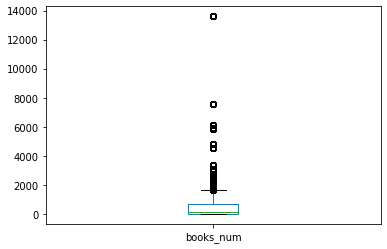

In [ ]:
interactions_uc.books_num.plot.box()

In [ ]:
interactions_uc = interactions_uc.loc[(interactions_uc["books_num"] < 4000) &
                    (interactions_uc.ISBN != '0971880107') &
                    (interactions_uc['Book-Rating'] != 0)
]

In [ ]:
interactions_uc = interactions_uc.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [ ]:
interactions_uc

User-ID  ...                                         Book-Title
0          2313  ...                               Flesh Tones: A Novel
1          8680  ...                               Flesh Tones: A Novel
2         10314  ...                               Flesh Tones: A Novel
3         50403  ...                               Flesh Tones: A Novel
4         63970  ...                               Flesh Tones: A Novel
...         ...  ...                                                ...
367875   276221  ...  The Science Book for Girls: And Other Intellig...
367876   276265  ...  The Art of Questioning : Thirty Maxims of Cros...
367877   276618  ...  Ludwig Marum: Briefe aus dem Konzentrationslag...
367878   276647  ...    Heaven (Coretta Scott King Author Award Winner)
367879   276660  ...                           ROBOT RACE (MICRO ADV 6)

[367880 rows x 7 columns]

In [ ]:
from sklearn import preprocessing
books_transform = preprocessing.LabelEncoder()
users_transform = preprocessing.LabelEncoder()
interactions_uc["product_id"] = books_transform.fit_transform(interactions_uc["Book-Title"])
interactions_uc["vid"] = users_transform.fit_transform(interactions_uc["User-ID"])

In [ ]:
interactions_uc.head()

User-ID        ISBN  Book-Rating  ...            Book-Title  product_id    vid
0     2313  034545104X            5  ...  Flesh Tones: A Novel       37148    563
1     8680  034545104X            5  ...  Flesh Tones: A Novel       37148   2043
2    10314  034545104X            9  ...  Flesh Tones: A Novel       37148   2392
3    50403  034545104X            9  ...  Flesh Tones: A Novel       37148  12277
4    63970  034545104X            8  ...  Flesh Tones: A Novel       37148  15691

[5 rows x 9 columns]

In [ ]:
csr_rates = coo_matrix((interactions_uc["Book-Rating"], (interactions_uc["vid"], interactions_uc["product_id"])), 
                            shape=(len(set(interactions_uc["vid"])), len(set(interactions_uc["product_id"]))))

In [ ]:
print(csr_rates)

  (563, 37148)	5
  (2043, 37148)	5
  (2392, 37148)	9
  (12277, 37148)	9
  (15691, 37148)	8
  (18935, 37148)	8
  (23048, 37148)	5
  (27376, 37148)	6
  (28204, 37148)	5
  (31309, 37148)	7
  (31368, 37148)	5
  (31592, 37148)	7
  (41841, 37148)	5
  (45833, 37148)	4
  (50632, 37148)	6
  (51244, 37148)	9
  (52047, 37148)	10
  (53576, 37148)	3
  (55409, 37148)	3
  (58428, 37148)	3
  (59213, 37148)	9
  (59519, 37148)	8
  (62321, 37148)	6
  (62826, 37148)	5
  (63615, 37148)	3
  :	:
  (66818, 87143)	7
  (66822, 77341)	8
  (66831, 68474)	4
  (66836, 50364)	4
  (66838, 26406)	5
  (66847, 31892)	8
  (66859, 27059)	7
  (66860, 105971)	10
  (66861, 93396)	6
  (66965, 113109)	10
  (66976, 103801)	6
  (66992, 84558)	7
  (67044, 39657)	2
  (67081, 74404)	5
  (67100, 39847)	7
  (67112, 60406)	7
  (67152, 49665)	7
  (67206, 48831)	10
  (67222, 58794)	10
  (67243, 93622)	5
  (67244, 111907)	8
  (67257, 94837)	7
  (67325, 61287)	5
  (67333, 44473)	10
  (67338, 79017)	8


In [ ]:
def get_data_coo_matrix(matrix, users_count, books_count, encoder=books_transform, users=None):
    temp = matrix.tocsr()
    if users is not None:
         temp = temp[users, :]
    nonzero_rows = temp.getnnz(axis=1)
    nonzero_cols = temp.getnnz(axis=0)
    rows = nonzero_rows.argsort()[-users_count:][::-1]
    cols = nonzero_cols.argsort()[-books_count:][::-1]
    return pd.DataFrame(data = [[temp[user, book] for book in cols] for user in rows], index=rows, columns=encoder.inverse_transform(cols))
most_rated = get_data_coo_matrix(csr_rates, 18, 30)

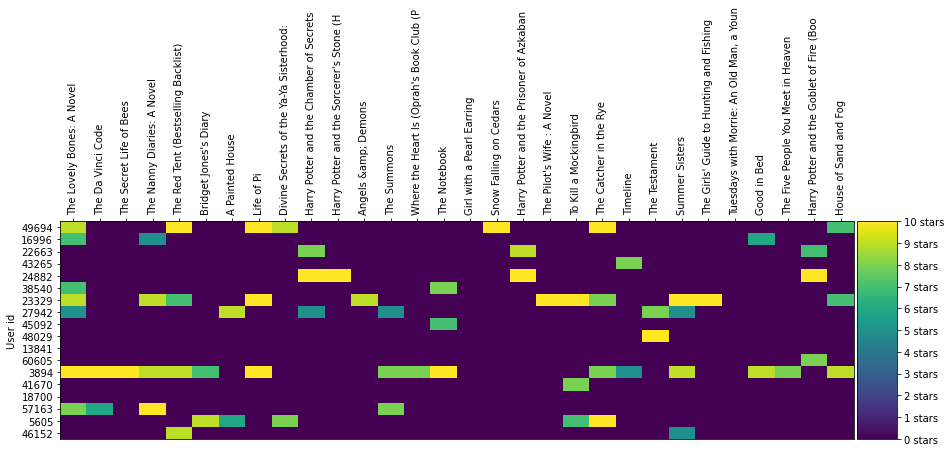

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def draw_movies_heatmap(most_rated_books, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    heatmap = ax.imshow(most_rated_books,  interpolation='nearest', vmin=0, vmax=10, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_books.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_books.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_books.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_books.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(heatmap, ticks=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['10 stars', '9 stars','8 stars','7 stars','6 stars', '5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
plt.show()

draw_movies_heatmap(most_rated)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

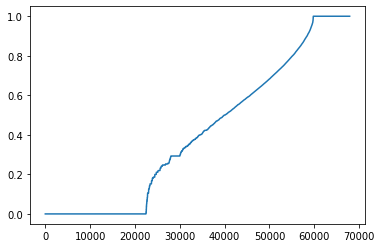

In [ ]:
def find_eps(df):
  neigh = NearestNeighbors(n_neighbors=2, metric='cosine')
  nbrs = neigh.fit(df)
  distances, indices = nbrs.kneighbors(df)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.plot(distances)
  plt.show()
find_eps(csr_rates)

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples=2, metric='cosine')
dbscan.fit(csr_rates)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [ ]:
labels = dbscan.labels_
np.unique(labels).shape[0]

835

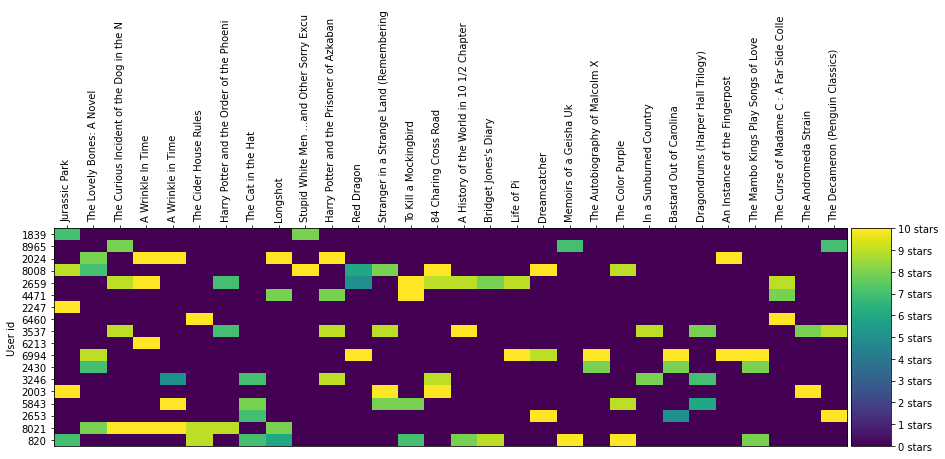

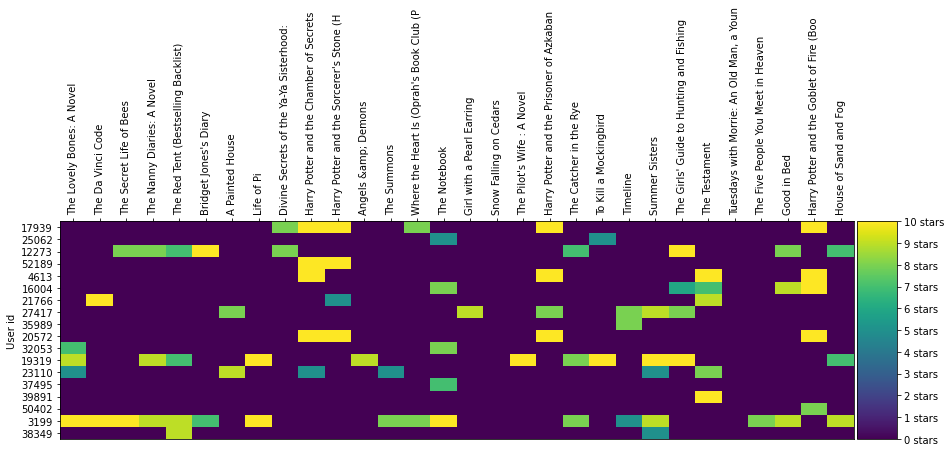

In [ ]:
for clust in [-1, 0]:
    most_rated = get_data_coo_matrix(csr_rates, 18, 30, users=np.where(labels == clust)[0])
    draw_movies_heatmap(most_rated)

Как видно на кластеры мы разбили не очень хорошо, т.к. в идеале мы должны были увидеть картину, где значения в каждом столбце имеют примерно одинаковую палитру. Но все-таки цель задания не в кластеризации)(

In [ ]:
class UserClustering():
    def __init__(self, data=interactions_uc):
        self.data = data
    
    def get_book_score(self, data, b=2):
        max_user_num = data.user_num.max()
        max_rating = data['Book-Rating'].max()
        temp = data.groupby(by=['user_num', 'Book-Title'])['Book-Rating'].mean().reset_index()
        temp = pd.merge(temp, data[['Book-Title', 'picture_url']].drop_duplicates(subset='Book-Title'), how='inner', on='Book-Title')
        temp['Book-Rating'] = temp['Book-Rating'] / max_rating
        temp['user_num'] = temp['user_num'] / max_user_num
        temp = temp.assign(score = (1 + b**2) * (temp['Book-Rating'] * temp['user_num'])/ ((b**2 * temp['user_num']) + temp['Book-Rating'])).sort_values(by='score', ascending=False)
        return temp

    def top_items(self, users, top_count=10):
        suitable_data = interactions_uc.loc[interactions_uc['vid'].isin(users)]
        book_score = self.get_book_score(suitable_data)
        if book_score.shape[0] == 0:
            print("Sorry, but we don't have suitable recommendation for you")
            return
        rec_imaging(book_score[:top_count])
        return book_score

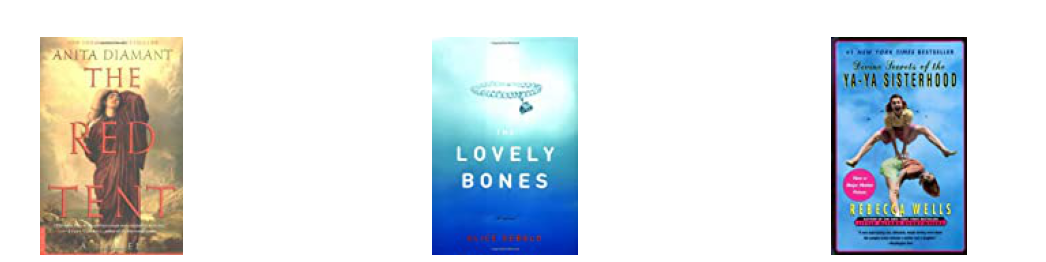

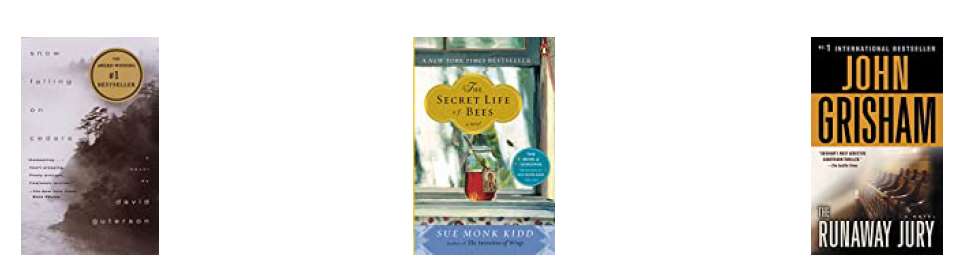

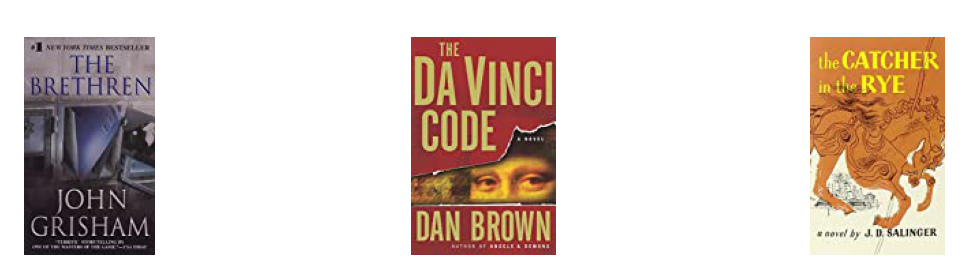

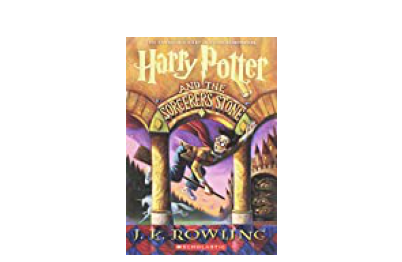

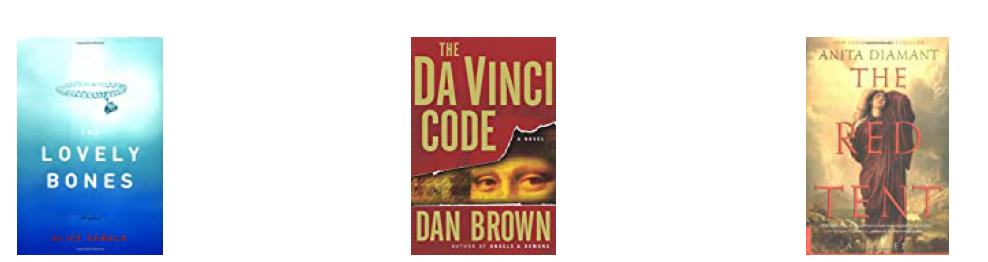

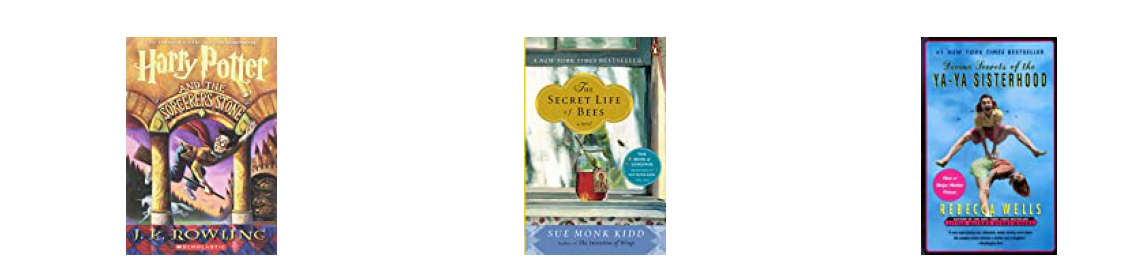

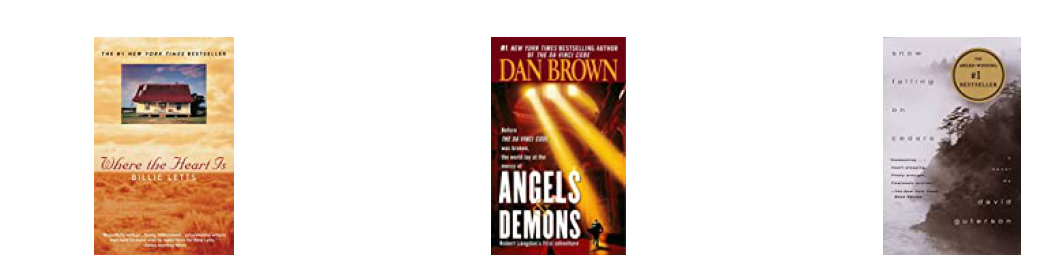

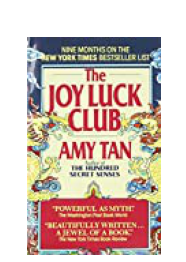

In [ ]:
for clust in [-1, 0]:
    a = UserClustering()
    check = a.top_items(users=np.where(labels == clust)[0])

# 3

## Совстречаемость

В данном случе нам необходимо найти пользователей, которые читали данную книгу. Затем составить таблицу вида: [данная книга, url_данной книг, другая книга, средняя оценка другой книги, url другой книги, количество совстречаемостей двух эти книг]. Будем использовать метрику, предложенную раньше, только b = 1, т.к. в данном случае количество совстречаемостей не менее важно чем рейтинг, а может и более, но предположим, что экспертная оценка важности 1 к 1.

In [ ]:
inter = interactions_uc.copy()

In [ ]:
inter

User-ID        ISBN  ...  product_id    vid
0          2313  034545104X  ...       37148    563
1          8680  034545104X  ...       37148   2043
2         10314  034545104X  ...       37148   2392
3         50403  034545104X  ...       37148  12277
4         63970  034545104X  ...       37148  15691
...         ...         ...  ...         ...    ...
367875   276221  1550741136  ...      111907  67244
367876   276265  0020130902  ...       94837  67257
367877   276618  3788097000  ...       61287  67325
367878   276647  0689822294  ...       44473  67333
367879   276660  0583307841  ...       79017  67338

[367880 rows x 9 columns]

In [ ]:
inter.nlargest(10, 'user_num')

User-ID        ISBN  ...  product_id    vid
7602    23768  0316666343  ...      106418   5562
7603    81977  0316666343  ...      106418  20021
7604   128045  0316666343  ...      106418  31309
7605   168816  0316666343  ...      106418  41054
7606   173743  0316666343  ...      106418  42308
7607   227447  0316666343  ...      106418  55308
7608   260897  0316666343  ...      106418  63615
7609   271448  0316666343  ...      106418  66182
7610      638  0316666343  ...      106418    146
7611     8253  0316666343  ...      106418   1964

[10 rows x 9 columns]

In [ ]:
from collections import Counter

In [ ]:
class Recomendations():
    def __init__(self, Int):
        self.book_scores = Int.groupby(by='Book-Title')['Book-Rating'].mean().reset_index()
        self.book_scores = pd.merge(self.book_scores, Int[['Book-Title', 'picture_url']].drop_duplicates(subset='Book-Title'), how='inner', on='Book-Title')
        self.interactions = Int

    def get_book_score(self, data, b=1):
        max_user_num = data.Counter.max()
        max_rating = data['Book-Rating'].max()
        temp = data.assign(score = (1 + b**2) * (data['Book-Rating'] * data['Counter'])/ ((b**2 * data['Counter']) + data['Book-Rating'])).sort_values(by='score', ascending=False)
        return temp
    
    def get_rec(self, book, top_count = 10):
        suitable_interactions = self.interactions.loc[self.interactions['Book-Title'].eq(book), 'vid']

        books_coop = Counter()

        for coop in self.interactions.loc[(self.interactions.vid.isin(suitable_interactions)) & (self.interactions['Book-Title'] != book), 'Book-Title']:
            books_coop[coop] += 1

        if len(books_coop) == 0:
            print("Sorry, but we don't have suitable recommendation for you")
            return
        
        books_coop = pd.DataFrame.from_dict(books_coop, orient='index').reset_index().rename(columns={'index': 'Book-Title', 0: 'Counter'})

        data = pd.merge(self.book_scores, books_coop, how='inner', on='Book-Title')
        books = self.get_book_score(data)
        rec_imaging(books[:top_count])

        return books

In [ ]:
a = Recomendations(inter)

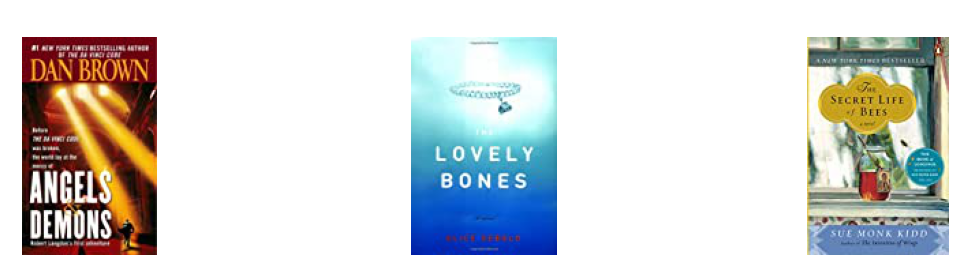

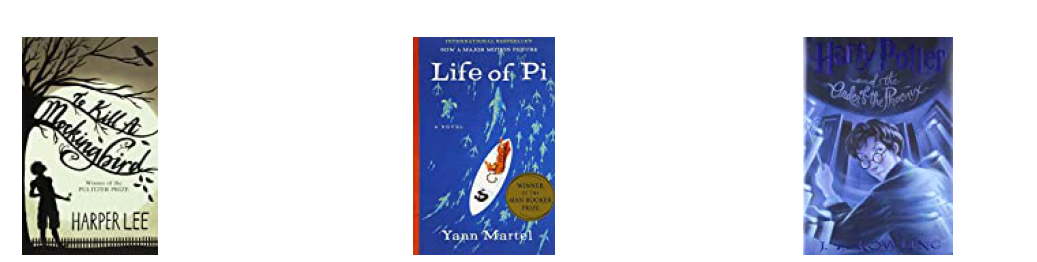

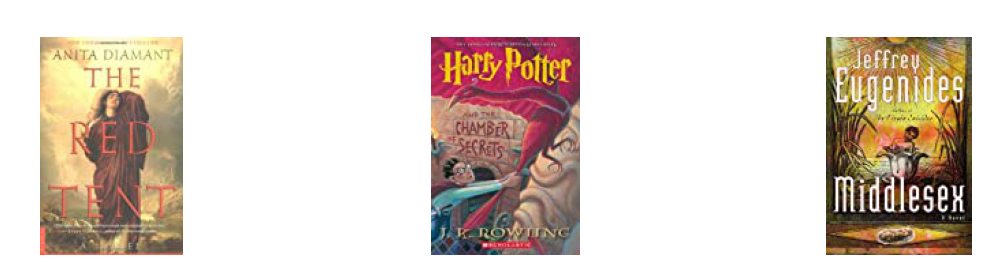

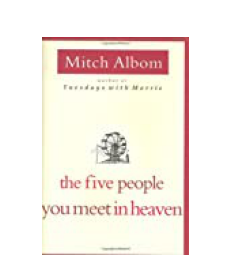

In [ ]:
check = a.get_rec('The Da Vinci Code')

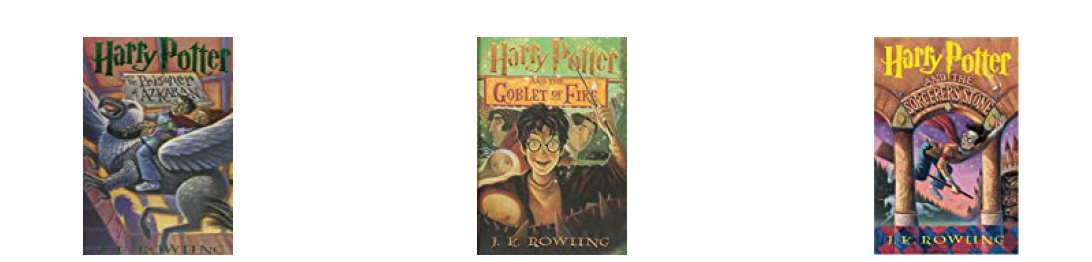

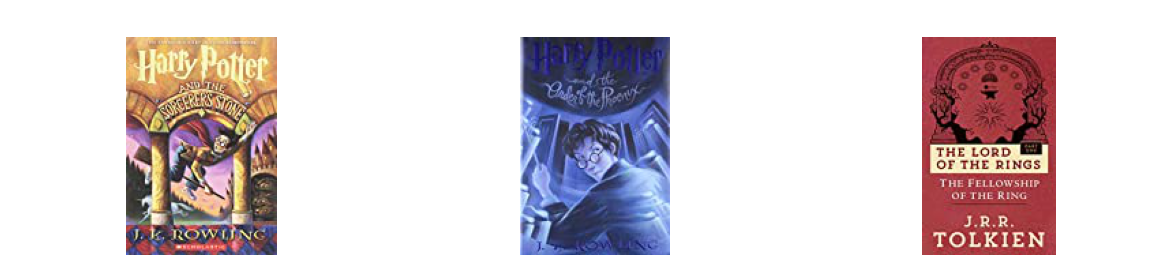

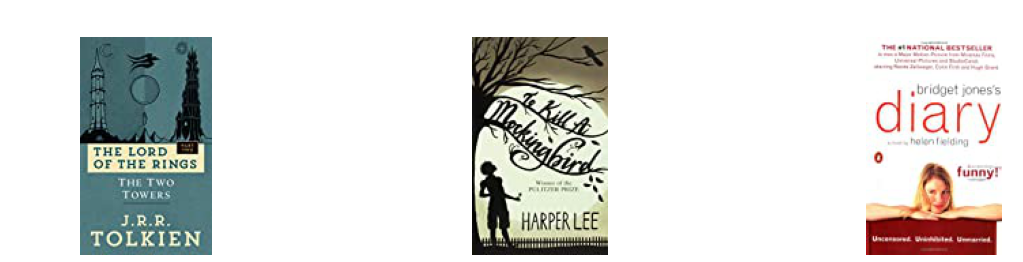

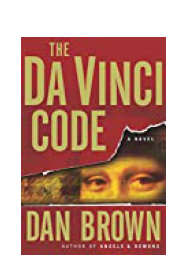

In [ ]:
check = a.get_rec('Harry Potter and the Chamber of Secrets (Book 2)')

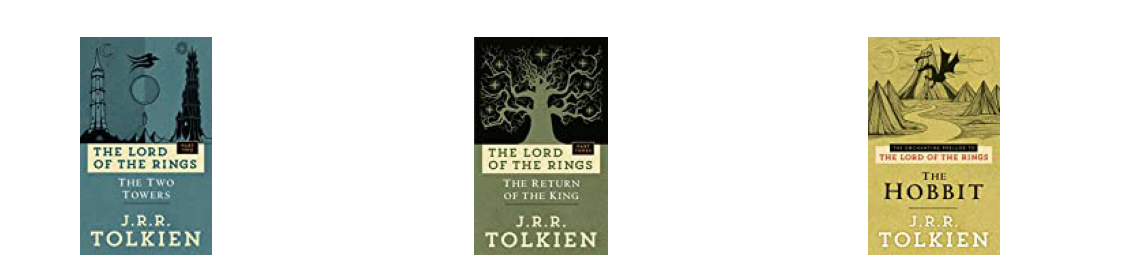

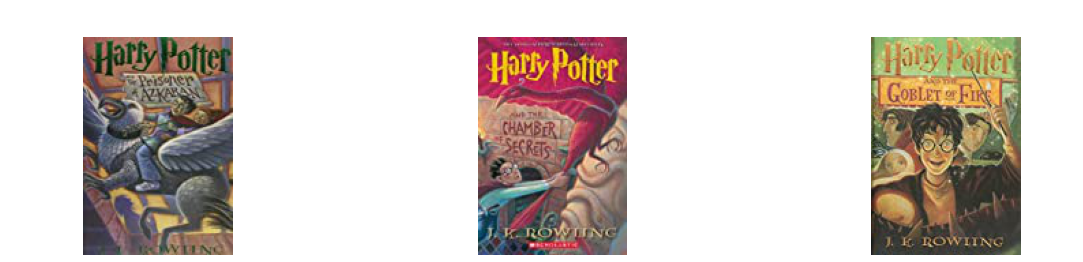

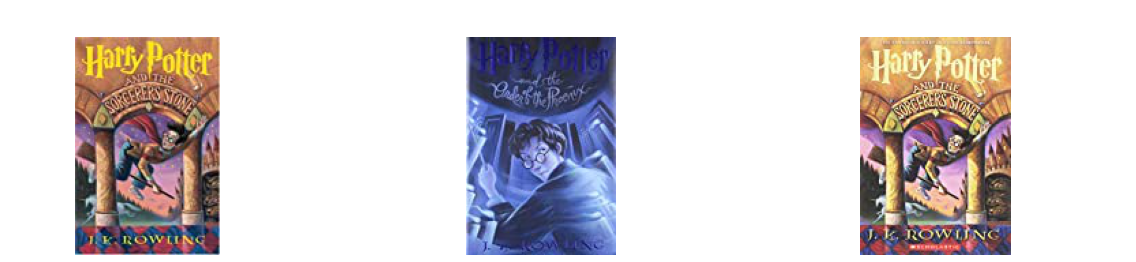

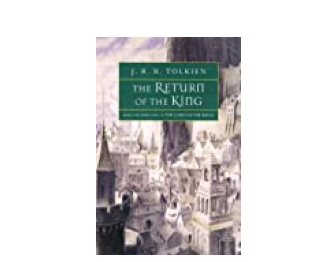

In [ ]:
check = a.get_rec('The Fellowship of the Ring (The Lord of the Rings, Part 1)')

## Content-based

Для Content-based рекомендаций нам необходимо представить описание товаров в виде вектора. Для I2I каждое описание книги будет представлять вектор, когда на вход модель будет приходить книга, будем искать ближайшие книги, используя косинусное расстояние и выводить топ книг, основываяссь на этой метрике. Для U2I будем переводить сессию пользователя в вектор, где сессия пользователя это все его прочитанные книги. Затем, когда на вход будет подаваться пользователь, будем вычислять косинусное расстояние между ним и книгами.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [ ]:
inter

User-ID        ISBN  ...  product_id    vid
0          2313  034545104X  ...       37148    563
1          8680  034545104X  ...       37148   2043
2         10314  034545104X  ...       37148   2392
3         50403  034545104X  ...       37148  12277
4         63970  034545104X  ...       37148  15691
...         ...         ...  ...         ...    ...
367875   276221  1550741136  ...      111907  67244
367876   276265  0020130902  ...       94837  67257
367877   276618  3788097000  ...       61287  67325
367878   276647  0689822294  ...       44473  67333
367879   276660  0583307841  ...       79017  67338

[367880 rows x 9 columns]

In [ ]:
class ContentBased():
    def __init__(self, Int):
        self.interactions = Int
        self.I2I_df = self.interactions[['Book-Title', 'picture_url']].drop_duplicates(subset='Book-Title').reset_index(drop=True)
        self.U2I_df = self.interactions.groupby(['User-ID'])['Book-Title'].apply(lambda x: ' '.join(x)).reset_index()
        self.items_embs = self.get_items_representation(self.I2I_df)


    def avg_feature_vector(self, words, num_features):
    
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in self.index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, self.model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self, df):

        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) for i in df['Book-Title']]

        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        items_embs = np.zeros((len(item_description), 200))
        for i in range(items_embs.shape[0]):
            items_embs[i] = self.avg_feature_vector(item_description[i], 200)
        return items_embs

    def get_books(self, user):
        books = self.interactions['Book-Title'].loc[self.interactions['User-ID'].eq(user)].drop_duplicates()
        return self.I2I_df.loc[self.I2I_df['Book-Title'].isin(books)].index

    def recommend_I2I(self, book, top_n = 10):
        ind = self.I2I_df[self.I2I_df['Book-Title'].eq(book)].index[0]
        ind_books = cosine_similarity(self.items_embs, self.items_embs[ind].reshape(1, -1))[:, 0].argsort()[-(top_n+1):-1][::-1]
        print("#"*10)
        print('Для книги:')
        response = requests.get(self.I2I_df.iloc[ind]['picture_url'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(self.I2I_df.iloc[ind]['Book-Title'], color='white')
        plt.show()
        print('Следующие рекомендации')
        rec_imaging(self.I2I_df.iloc[ind_books])

    def recommend_U2I(self, user, top_n=10):
        ind = self.U2I_df[self.U2I_df['User-ID'].eq(user)].index[0]
        user_vector = self.U2I_df['Book-Title'][ind]
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, 200)
        ind_books = cosine_similarity(self.items_embs, user_emb.reshape(1, -1))[:, 0]
        ind_books = np.delete(ind_books, self.get_books(user)).argsort()[-top_n:][::-1]
        print('#'*10)
        print('Для пользователя, который читал след.книги')
        rec_imaging(self.interactions.loc[self.interactions['User-ID'].eq(user)].sample(3))
        print('#'*10)
        print('такие рекомендации')
        rec_imaging(self.I2I_df.iloc[ind_books])

In [ ]:
A = ContentBased(inter)

##########
Для книги:


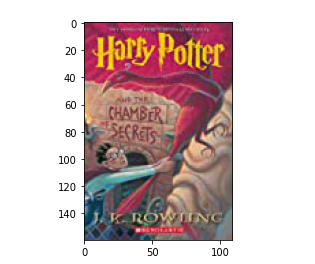

Следующие рекомендации


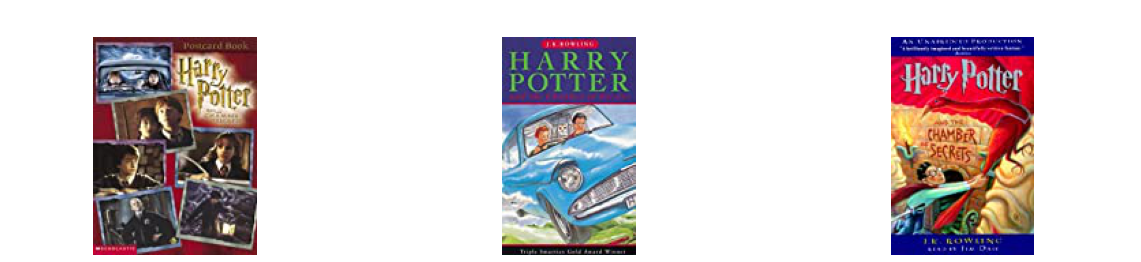

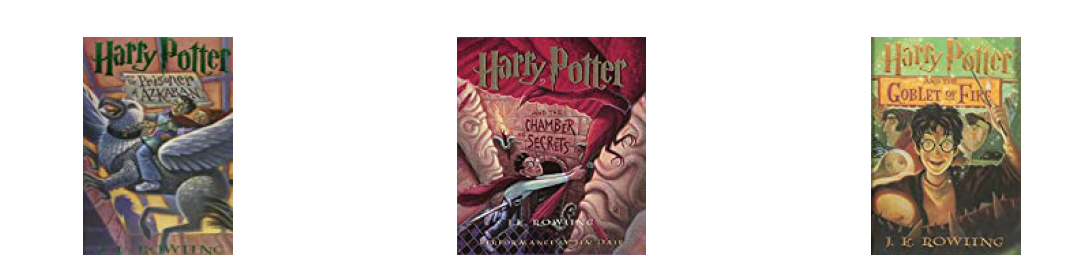

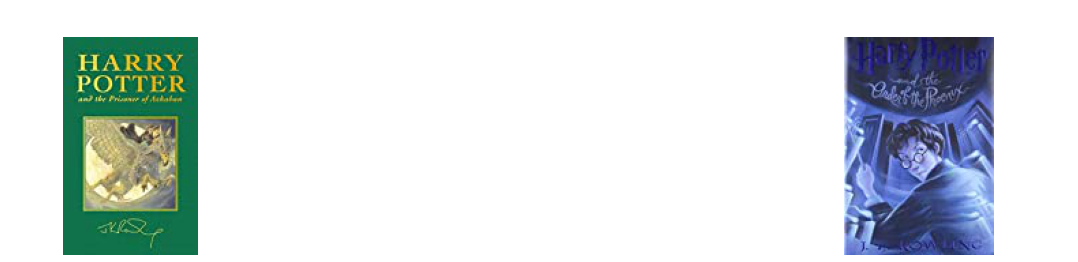

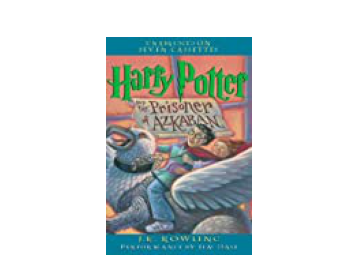

In [ ]:
A.recommend_I2I('Harry Potter and the Chamber of Secrets (Book 2)')

##########
Для пользователя, который читал след.книги


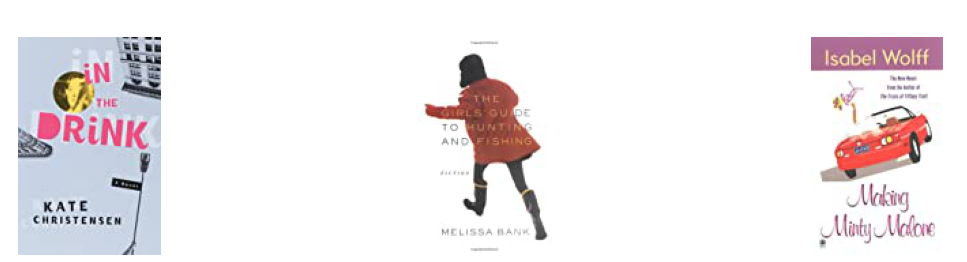

##########
такие рекомендации


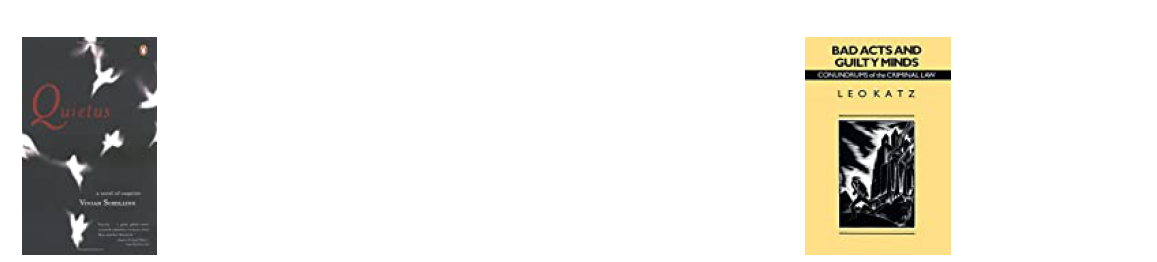

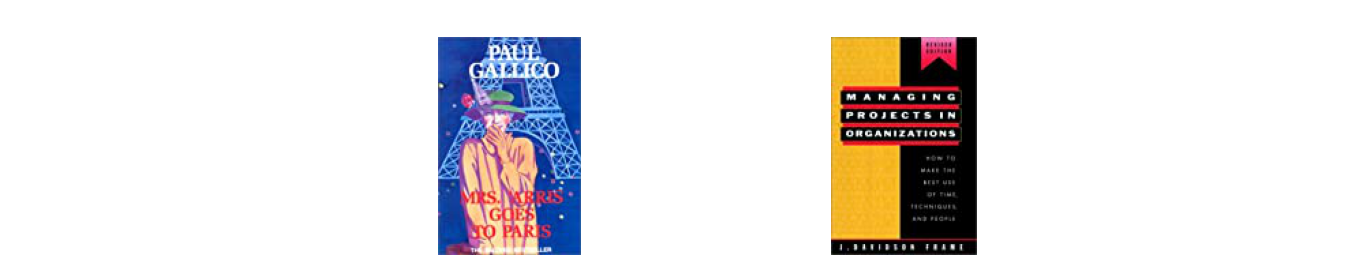

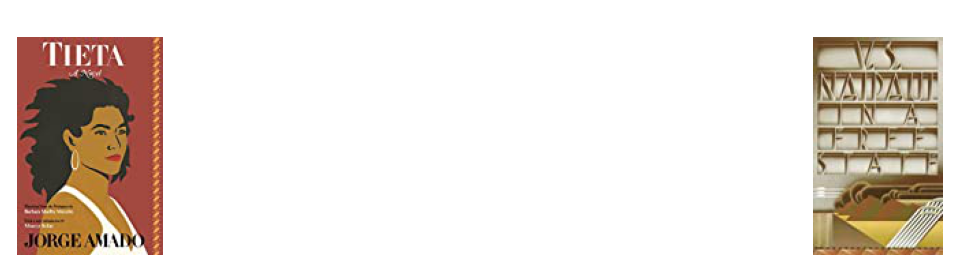

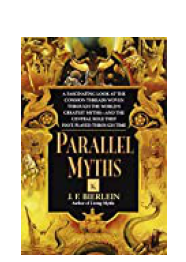

In [ ]:
A.recommend_U2I(173728)

## Collaborative filtering